In [1]:
### Internet Firewall Data

### Additional Information


##### There are 12 features in total. Action feature is used as a class. There are 4 classes in total. These are allow, action, drop and reset-both classes.

In [2]:
###!pip install keras-tuner

In [3]:
###! unzip /content/internet+firewall+data.zip

In [4]:
###! pip install tensorflow
###! pip install bayesian-optimization

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
###from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [6]:
log_data = pd.read_csv("/content/log2.csv")

In [7]:
log_data.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

In [8]:
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
training_data, testing_data = train_test_split(log_data, test_size = 0.3, random_state = 0)

In [11]:
print(training_data.shape, testing_data.shape)

(45872, 12) (19660, 12)


In [12]:
training_data['ID'] = training_data.index
testing_data['ID'] = testing_data.index


In [13]:
###! pip install matplotlib_venn
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

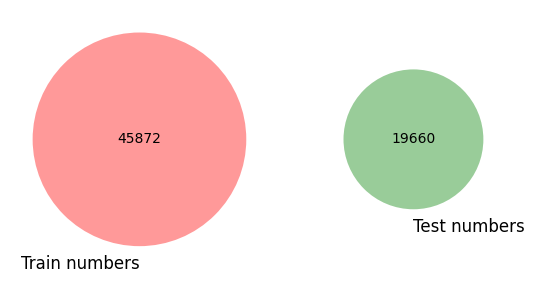

In [14]:
set_numbers_train = set(training_data[['ID']].drop_duplicates().sort_values(by = 'ID')['ID'].tolist())
set_numbers_test = set(testing_data[['ID']].drop_duplicates().sort_values(by = 'ID')['ID'].tolist())
venn2((set_numbers_train, set_numbers_test), set_labels = ('Train numbers', 'Test numbers'))

In [15]:
training_data.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received', 'ID'],
      dtype='object')

In [16]:
num_var = [feature for feature in training_data.columns if training_data[feature].dtypes != 'O']
discrete_var = [feature for feature in num_var if len(training_data[feature].unique()) <= 25]
cont_var = [feature for feature in num_var if feature not in discrete_var]
categ_var = [feature for feature in training_data.columns if feature not in num_var]

In [17]:
###! pip install klib
####!pip install keras-tuner

In [18]:
import klib

In [19]:
training_data = klib.clean_column_names(training_data)
testing_data = klib.clean_column_names(testing_data)

GridSpec(6, 1)

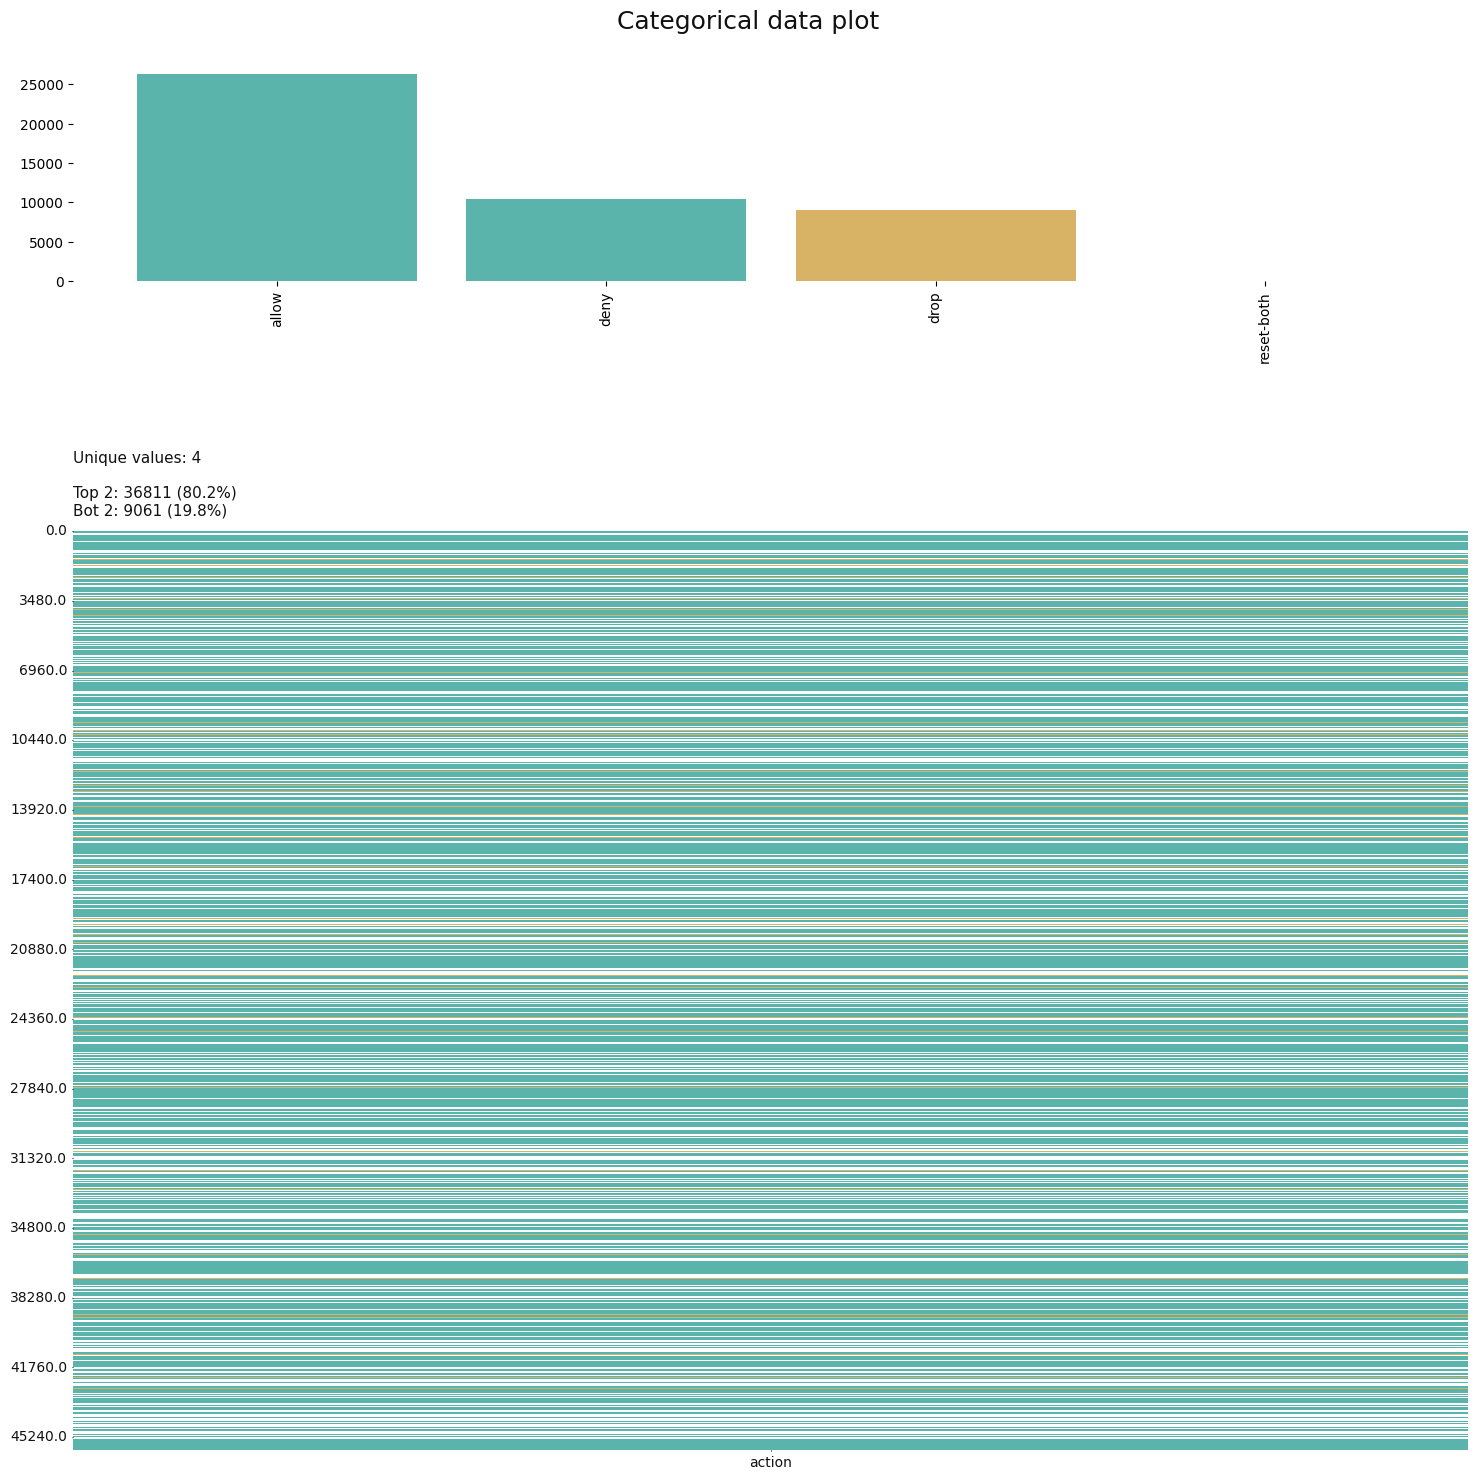

In [20]:
klib.cat_plot(training_data)

In [21]:
klib.corr_interactive_plot(training_data)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='source_port', ylabel='Density'>

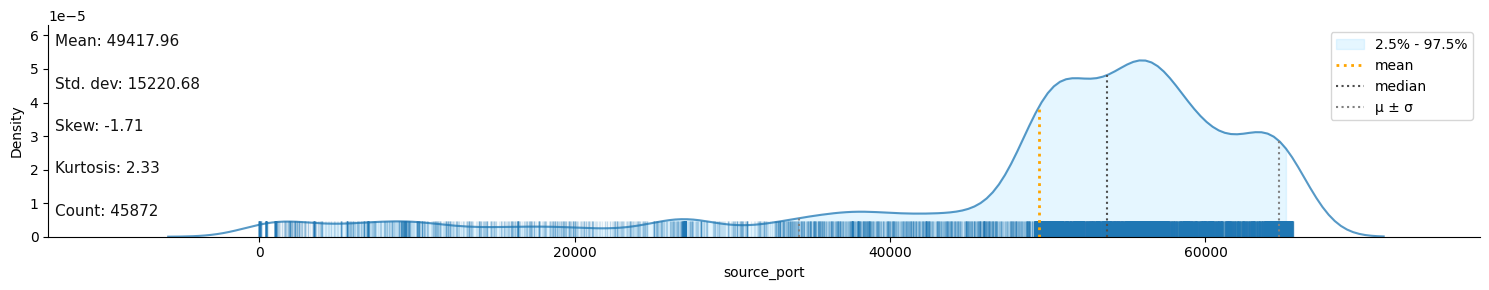

In [22]:
klib.dist_plot(training_data)

In [23]:
klib.missingval_plot(training_data)

No missing values found in the dataset.


In [24]:
klib.corr_mat(training_data)

,source_port,destination_port,nat_source_port,nat_destination_port,bytes,bytes_sent,bytes_received,packets,elapsed_time_sec,pkts_sent,pkts_received,id
source_port,1.00,-0.33,0.14,-0.03,-0.00,-0.00,0.00,-0.00,-0.05,-0.00,-0.00,-0.00
destination_port,-0.33,1.00,-0.28,0.41,-0.00,0.00,-0.01,-0.00,0.02,-0.00,-0.01,0.01
nat_source_port,0.14,-0.28,1.00,0.18,0.01,0.00,0.02,0.01,0.14,0.01,0.02,0.01
nat_destination_port,-0.03,0.41,0.18,1.00,0.01,0.01,-0.00,0.01,0.22,0.01,0.00,0.03
bytes,-0.00,-0.00,0.01,0.01,1.00,0.96,0.86,0.97,0.16,0.99,0.85,-0.00
bytes_sent,-0.00,0.00,0.00,0.01,0.96,1.00,0.68,0.91,0.15,0.98,0.71,-0.00
bytes_received,0.00,-0.01,0.02,-0.00,0.86,0.68,1.00,0.89,0.14,0.80,0.94,0.00
packets,-0.00,-0.00,0.01,0.01,0.97,0.91,0.89,1.00,0.16,0.98,0.94,0.00
elapsed_time_sec,-0.05,0.02,0.14,0.22,0.16,0.15,0.14,0.16,1.00,0.16,0.14,0.02
pkts_sent,-0.00,-0.00,0.01,0.01,0.99,0.98,0.80,0.98,0.16,1.00,0.84,-0.00


In [25]:
training_data.columns

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_sec', 'pkts_sent',
       'pkts_received', 'id'],
      dtype='object')

In [26]:
# Checking for outliers in the continuous variables
num_train_dataset = training_data[['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_sec', 'pkts_sent',
       'pkts_received', 'id']]


In [27]:
training_data['action'].value_counts()

action
allow         26311
deny          10500
drop           9021
reset-both       40
Name: count, dtype: int64

In [28]:
training_data['action'] = training_data['action'].astype('category').cat.codes
testing_data['action'] = testing_data['action'].astype('category').cat.codes

In [29]:
training_data['action'].value_counts()

action
0    26311
1    10500
2     9021
3       40
Name: count, dtype: int64

In [30]:
y_train = training_data['action']
x_train = training_data.drop('action', axis = 1)
y_test = testing_data['action']
x_test = testing_data.drop('action', axis = 1)

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 2)
extra_tree_forest.fit(x_train, y_train)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [32]:
feature_importance_normalized

array([0.05675952, 0.16426633, 0.11188091, 0.06129195, 0.00335718,
       0.00493371, 0.00305258, 0.0187216 , 0.0243437 , 0.01163417,
       0.01434409, 0.01811124])

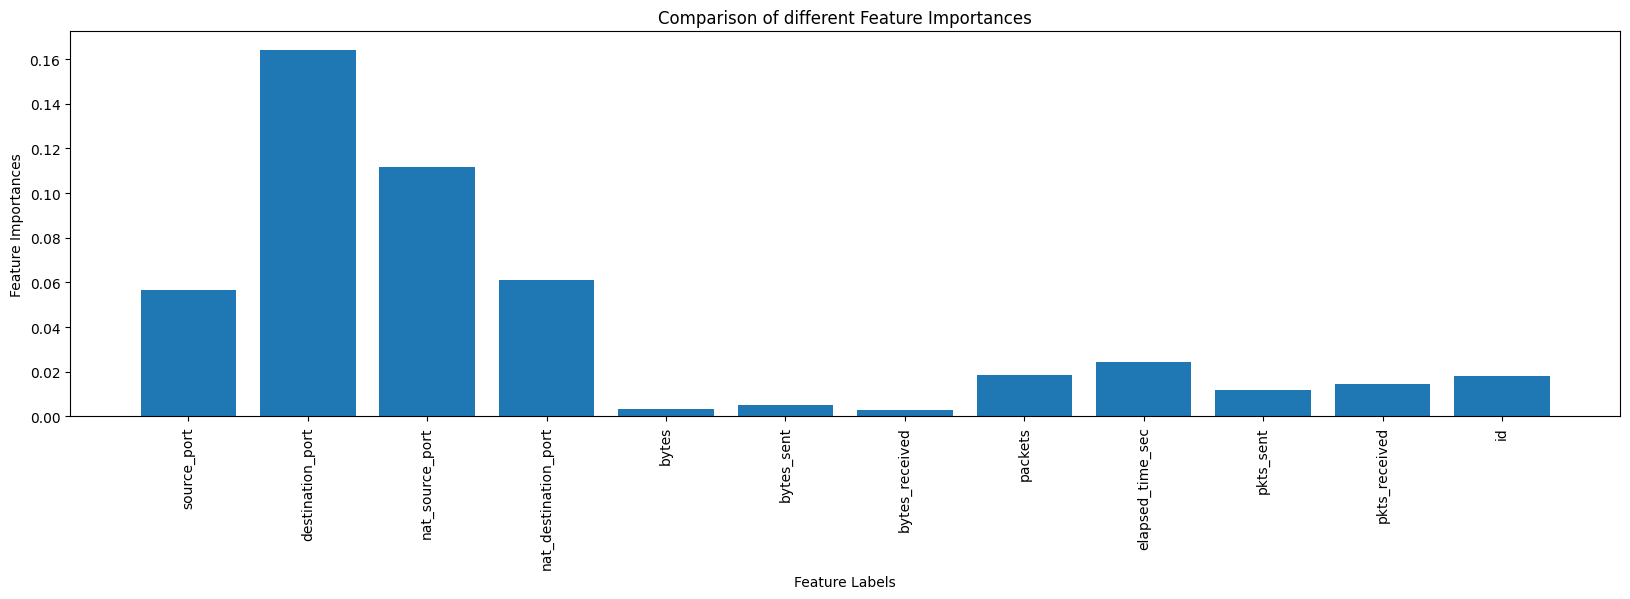

In [33]:
plt.figure(figsize = [20,5])
plt.bar(x_train.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.xticks(rotation = 90)
plt.title('Comparison of different Feature Importances')
plt.show()

In [34]:
print("The columns of the x_train :", x_train.columns)
print("The columns of the x_test :", x_test.columns)

The columns of the x_train : Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'bytes', 'bytes_sent', 'bytes_received',
       'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received', 'id'],
      dtype='object')
The columns of the x_test : Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'bytes', 'bytes_sent', 'bytes_received',
       'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received', 'id'],
      dtype='object')


In [35]:
x_train2 = x_train[['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'bytes', 'bytes_sent', 'bytes_received',
       'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received']]

In [36]:
x_test2 = x_test[['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'bytes', 'bytes_sent', 'bytes_received',
       'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received']]

In [37]:
print(x_train2.shape, x_test2.shape)

(45872, 11) (19660, 11)


In [38]:
y_train.value_counts()

action
0    26311
1    10500
2     9021
3       40
Name: count, dtype: int64

In [39]:
x_train2 = pd.DataFrame(x_train2)
x_test2 = pd.DataFrame(x_test2)

### Pearson Correlation

In [40]:
x_train2.astype(float).corr()

,source_port,destination_port,nat_source_port,nat_destination_port,bytes,bytes_sent,bytes_received,packets,elapsed_time_sec,pkts_sent,pkts_received
source_port,1.000000,-0.332822,0.144624,-0.026874,-0.000384,-0.001174,0.001163,-0.002848,-0.045490,-0.002032,-0.003874
destination_port,-0.332822,1.000000,-0.281346,0.410776,-0.003970,0.002086,-0.014347,-0.004812,0.023451,-0.001526,-0.009608
nat_source_port,0.144624,-0.281346,1.000000,0.176844,0.010345,0.002506,0.022666,0.012151,0.141599,0.007036,0.019156
nat_destination_port,-0.026874,0.410776,0.176844,1.000000,0.005874,0.009378,-0.001877,0.006277,0.219658,0.007417,0.003822
bytes,-0.000384,-0.003970,0.010345,0.005874,1.000000,0.961022,0.858692,0.974205,0.159429,0.989239,0.853142
bytes_sent,-0.001174,0.002086,0.002506,0.009378,0.961022,1.000000,0.683532,0.907204,0.148848,0.975093,0.707939
bytes_received,0.001163,-0.014347,0.022666,-0.001877,0.858692,0.683532,1.000000,0.890350,0.144997,0.804198,0.940104
packets,-0.002848,-0.004812,0.012151,0.006277,0.974205,0.907204,0.890350,1.000000,0.158293,0.976507,0.938233
elapsed_time_sec,-0.045490,0.023451,0.141599,0.219658,0.159429,0.148848,0.144997,0.158293,1.000000,0.156879,0.144815
pkts_sent,-0.002032,-0.001526,0.007036,0.007417,0.989239,0.975093,0.804198,0.976507,0.156879,1.000000,0.841632


In [41]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [42]:
print(x_test2.columns, x_train2.columns)

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'bytes', 'bytes_sent', 'bytes_received',
       'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received'],
      dtype='object') Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'bytes', 'bytes_sent', 'bytes_received',
       'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received'],
      dtype='object')


In [ ]:
###!pip install pycaret
###! pip install jinja2
###! pip install markupsafe==2.0.1

In [81]:
import pycaret
from pycaret.classification import *

In [83]:
print(training_data.shape, testing_data.shape)

(45872, 13) (19660, 13)


In [84]:
training_data.columns

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_sec', 'pkts_sent',
       'pkts_received', 'id'],
      dtype='object')

In [85]:
model= setup(data= training_data, target= 'action')

,Description,Value
0,Session id,2131
1,Target,action
2,Target type,Multiclass
3,Original data shape,"(45872, 13)"
4,Transformed data shape,"(45872, 13)"
5,Transformed train set shape,"(32110, 13)"
6,Transformed test set shape,"(13762, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


In [86]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9986,0.9999,0.9986,0.9982,0.9984,0.9976,0.9976,32.1660
rf,Random Forest Classifier,0.9984,0.9997,0.9984,0.9978,0.9981,0.9972,0.9972,2.2140
et,Extra Trees Classifier,0.9983,0.9996,0.9983,0.9979,0.9981,0.9971,0.9971,1.3310
xgboost,Extreme Gradient Boosting,0.9983,0.9998,0.9983,0.9979,0.9981,0.9971,0.9971,1.6430
dt,Decision Tree Classifier,0.9980,0.9987,0.9980,0.9979,0.9979,0.9965,0.9965,0.1170
gbc,Gradient Boosting Classifier,0.9978,0.9992,0.9978,0.9976,0.9976,0.9961,0.9961,23.6360
ada,Ada Boost Classifier,0.9922,0.9982,0.9922,0.9917,0.9919,0.9867,0.9867,1.6200
lr,Logistic Regression,0.9879,0.9977,0.9879,0.9873,0.9875,0.9792,0.9793,6.5110
knn,K Neighbors Classifier,0.9858,0.9957,0.9858,0.9851,0.9854,0.9756,0.9756,0.5800
lightgbm,Light Gradient Boosting Machine,0.9687,0.9767,0.9687,0.9757,0.9691,0.9470,0.9487,4.6990


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [87]:
randomforest = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9984,0.9998,0.9984,0.9978,0.9981,0.9973,0.9973
1,0.9988,0.9994,0.9988,0.9988,0.9987,0.9979,0.9979
2,0.9991,0.9998,0.9991,0.9989,0.9990,0.9984,0.9984
3,0.9978,0.9998,0.9978,0.9978,0.9977,0.9962,0.9962
4,0.9984,1.0000,0.9984,0.9984,0.9984,0.9973,0.9973
5,0.9978,0.9994,0.9978,0.9969,0.9974,0.9962,0.9962
6,0.9991,1.0000,0.9991,0.9981,0.9986,0.9984,0.9984
7,0.9984,0.9994,0.9984,0.9975,0.9980,0.9973,0.9973
8,0.9978,0.9998,0.9978,0.9969,0.9974,0.9962,0.9962


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [88]:
pred_holdout = predict_model(randomforest, data= testing_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9979,0.9994,0.9979,0.9979,0.9977,0.9963,0.9963


In [89]:
pred_holdout.columns

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'bytes', 'bytes_sent', 'bytes_received',
       'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received', 'id',
       'action', 'prediction_label', 'prediction_score'],
      dtype='object')

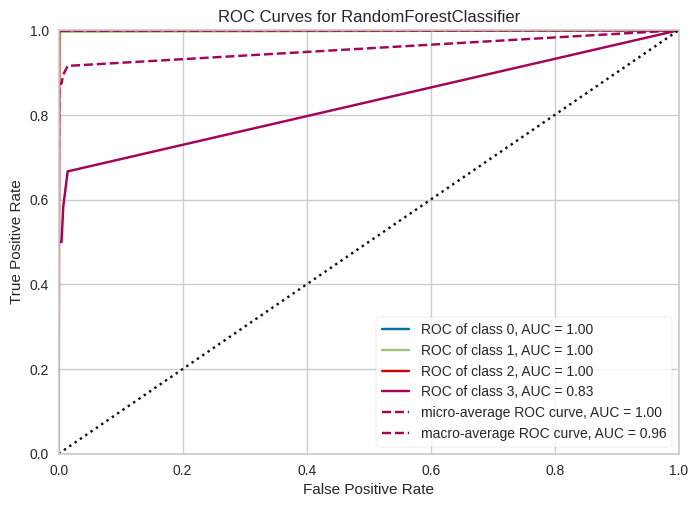

In [90]:
# AUC-ROC plot
plot_model(randomforest, plot = 'auc')

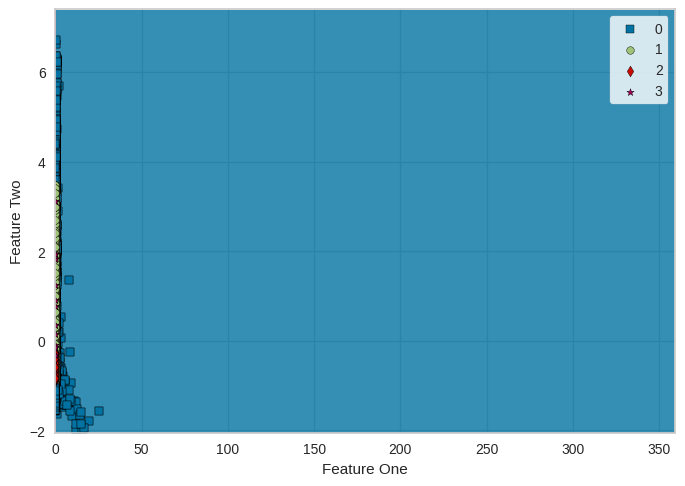

In [91]:
# Decision Boundary
plot_model(randomforest, plot = 'boundary')

In [92]:
###! pip install shap

In [93]:
import shap

In [94]:
tune_randomforest = tune_model(randomforest)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9984,0.9998,0.9984,0.9978,0.9981,0.9973,0.9973
1,0.9981,0.9993,0.9981,0.9975,0.9978,0.9968,0.9968
2,0.9988,0.9993,0.9988,0.9978,0.9983,0.9979,0.9979
3,0.9981,0.9996,0.9981,0.9972,0.9977,0.9968,0.9968
4,0.9978,0.9991,0.9978,0.9969,0.9974,0.9962,0.9962
5,0.9978,0.9995,0.9978,0.9969,0.9974,0.9962,0.9962
6,0.9988,0.9997,0.9988,0.9978,0.9983,0.9979,0.9979
7,0.9981,0.9996,0.9981,0.9972,0.9977,0.9968,0.9968
8,0.9972,0.9995,0.9972,0.9963,0.9967,0.9952,0.9952


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [95]:
print(tune_randomforest)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=2131, verbose=0,
                       warm_start=False)


In [96]:
predict_model(tune_randomforest)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9981,0.9993,0.9981,0.9981,0.9979,0.9967,0.9967


,source_port,destination_port,nat_source_port,nat_destination_port,bytes,bytes_sent,bytes_received,packets,elapsed_time_sec,pkts_sent,pkts_received,id,action,prediction_label,prediction_score
33873,58869,445,0,0,70,70,0,1,0,1,0,33873,2,2,1.0
59537,52027,445,0,0,66,66,0,1,0,1,0,59537,2,2,1.0
24581,55830,53,64690,53,183,94,89,2,30,1,1,24581,0,0,1.0
1724,65066,80,65066,80,874843,22526,852317,878,44,304,574,1724,0,0,1.0
46522,65378,53,28736,53,770,102,668,2,30,1,1,46522,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33470,13484,37965,0,0,62,62,0,1,0,1,0,33470,1,1,1.0
25312,24606,55783,0,0,72,72,0,1,0,1,0,25312,1,1,1.0
17978,61002,37965,0,0,145,145,0,1,0,1,0,17978,1,1,1.0
10142,49240,53,28241,53,198,101,97,2,30,1,1,10142,0,0,1.0


In [97]:
final_randomforest = finalize_model(tune_randomforest)
print(final_randomforest)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['source_port', 'destination_port',
                                             'nat_source_port',
                                             'nat_destination_port', 'bytes',
                                             'bytes_sent', 'bytes_received',
                                             'packets', 'elapsed_time_sec',
                                             'pkts_sent', 'pkts_received',
                                             'id'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=N...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criteri

In [98]:
print(training_data.shape, testing_data.shape)

(45872, 13) (19660, 13)


In [99]:
training_data['ID'] = training_data.index
testing_data['ID'] = testing_data.index


In [100]:
training_data.columns

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_sec', 'pkts_sent',
       'pkts_received', 'id', 'ID'],
      dtype='object')

In [101]:
training_data2 = training_data[['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_sec', 'pkts_sent',
       'pkts_received']]

In [102]:
testing_data2 = testing_data[['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_sec', 'pkts_sent',
       'pkts_received']]

In [103]:
X_train = training_data2.drop(columns= "action")
Y_train = training_data2["action"]

X_test = testing_data2.drop(columns= "action")
Y_test = testing_data2["action"]

In [104]:
final_randomforest.fit(X_train, Y_train)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['source_port', 'destination_port',
                                             'nat_source_port',
                                             'nat_destination_port', 'bytes',
                                             'bytes_sent', 'bytes_received',
                                             'packets', 'elapsed_time_sec',
                                             'pkts_sent', 'pkts_received',
                                             'id'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=N...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        monotonic_cst=None, n_estimators=100,
                                        n_jobs=-1, oob_score=False,
                                        random_state=2131, verbose=0,
                                        warm_start=False))],
         verbose=False)

In [105]:
Y_pred = final_randomforest.predict(X_test)

In [106]:
Y_pred = pd.DataFrame(Y_pred)

In [108]:
Y_pred.rename(columns = {0 : "pred_action"}, inplace = True)

In [109]:
Y_pred.shape

(19660, 1)

In [ ]:
###! pip install pickle

In [111]:
# Save the trained model as a pickle string.
import pickle

saved_model = pickle.dump(final_randomforest, open('/content/final_randomforest_latest.pkl','wb'))